# The Battle of Neighborhood
### Final Capstone Project on Coursera 
#### By:- Nidhi Goyal
PROJECT TITLE :
## ITALIAN RESTAURANT in New York City
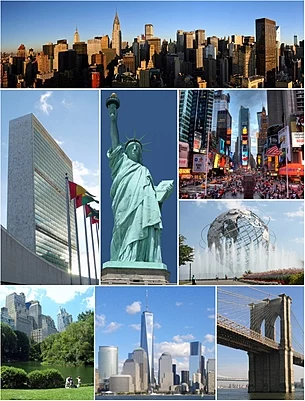

### 1. INTRODUCTION
#### 1A.Background & Problem Description
New York City, the most populous city in the United States, one of the greatest metropolises over the world, is a dream place for gourmet to seek delicious cuisine. Its food culture includes an array of international cuisines influenced by the city's immigrant history. Central and Eastern European immigrants, especially Jewish immigrants from those regions, brought bagels, cheesecake, hot dogs, knishes, and delicatessens (or delis) to the city. Italian immigrants brought New York-style pizza and Italian cuisine into the city, while Jewish immigrants and Irish immigrants brought pastrami and corned beef, respectively. Chinese and other Asian restaurants, sandwich joints, trattorias, diners, and coffeehouses are ubiquitous throughout the city. Some 4,000 mobile food vendors licensed by the city, many immigrant-owned, have made Middle Eastern foods such as falafel and kebabs examples of modern New York street food. The city is home to "nearly one thousand of the finest and most diverse haute cuisine restaurants in the world," according to Michelin. As of 2020, there were more then 27,000 restaurants in the city, up from 24,865 in 2017.

As the figures tell, New York City attracts many to start their business in the food industry. Before they take action, they need to find out where they would open it? What would they consider when selecting a location? By exploring the regional characteristics of these restaurants, I hope to figure out whether the neighborhood of restaurants is an essential factor for the success of a restaurant with sound analysis.

This report explores which neighborhoods and boroughs of New York City have the most as well as the best Italian restaurants. Additionally, I will attempt to answer the questions “Where should I open an Italian Restaurant?” and “Where should I stay If I want great Italian food?”

#### 1B. Data
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

### 2. Methodology
* Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.
* FourSquare be used to locate all venues and then filtered by Italian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.
* Data will be sorted based on rankings.
* Geopy is used to get the geological location of each community board.
* BeautifulSoup is used to scrape boroughs and organize a table containing Community Board, Area, Pop.Census, Neighborhoods information of New York City.
* Finally, the data be will be visually assessed using graphing from various Python libraries.

### 3.Problem Statement
1. What is / are the best location(s) for Italian cuisine in New York City?
2. In what Neighborhood and/or borough should I open an Italian restaurant to have the best chance of being successful?
3. Where would I go in New York City to have the best Italian food?
***
 
Lets start by loading Libraries

In [4]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

### Define Foursquare Credentials and Version
#### Make sure that you have created a Foursquare developer account and have your credentials handy

In [5]:
CLIENT_ID = 'EOIOTGSBHDOM5G4YB0BG534SSIRSU2JTMFSKOX51ZIEVYSZA' # your Foursquare ID
CLIENT_SECRET = 'DFKT24IPEQ2HA1ZKYVTSZMFC3JDFCWAABWRLMXTA2LW0QNHF' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EOIOTGSBHDOM5G4YB0BG534SSIRSU2JTMFSKOX51ZIEVYSZA
CLIENT_SECRET:DFKT24IPEQ2HA1ZKYVTSZMFC3JDFCWAABWRLMXTA2LW0QNHF


***
* Functions that will be used later. 
* Geopy is used to get the geological location of each community board. 
* The Foursquare API is utilized to explore the boroughs and segment them.

In [9]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Now lets use the above codes to get our initial NYC data

In [10]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
ny_data.shape

(306, 4)